## Prophet Model

At the beginning we need to iinstall necessary pacakage for prophet model. 

In [ ]:
#Install prophet package. 
%pip install prophet

In [1]:
#import necessary libraries 
import pandas as pd
from prophet import Prophet 
from prophet.diagnostics import cross_validation, performance_metrics
#to mute Pandas warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



For reproducibility we need to use seed vlaue.

In [2]:
#use seed for reproducibility
np.random.seed(0)


### Load data

In [3]:
#load data
final_data = pd.read_csv('../data/final_data_2010_2021.csv')

In [4]:
final_data.tail()

,DATETIME,TOTALDEMAND,TEMPERATURE,HOLIDAY,SUMMER,AUTUMN,WINTER,SPRING,MONTH,DAYOFWEEK,WEEKDAY,HOUR,PEAK
196507,2021-03-17 21:30:00,7503.12,19.7,0,0,1,0,0,3,2,1,21,1
196508,2021-03-17 22:00:00,7419.77,19.7,0,0,1,0,0,3,2,1,22,0
196509,2021-03-17 22:30:00,7417.91,19.5,0,0,1,0,0,3,2,1,22,0
196510,2021-03-17 23:00:00,7287.32,19.1,0,0,1,0,0,3,2,1,23,0
196511,2021-03-17 23:30:00,7172.39,18.8,0,0,1,0,0,3,2,1,23,0


### Data Preparation for the model

Change the DATETIME column to datetime format.

In [5]:
#change the format of the DATETIME column to datetime
df = final_data.copy()
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.dtypes

DATETIME       datetime64[ns]
TOTALDEMAND           float64
TEMPERATURE           float64
HOLIDAY                 int64
SUMMER                  int64
AUTUMN                  int64
WINTER                  int64
SPRING                  int64
MONTH                   int64
DAYOFWEEK               int64
WEEKDAY                 int64
HOUR                    int64
PEAK                    int64
dtype: object

For the model we need to convert the SUMMER, AUTUMN, WINTER, SPRING,  HOLIDAY, WEEKDAY and PEAK to boolean. And we also need the DAYOFWEEK to one-hot encoded. 

In [6]:
#changing the data type of the columns to boolean
df['SUMMER'] = df['SUMMER'].astype('bool')
df['AUTUMN'] = df['AUTUMN'].astype('bool')
df['WINTER'] = df['WINTER'].astype('bool')
df['SPRING'] = df['SPRING'].astype('bool')
df['HOLIDAY'] = df['HOLIDAY'].astype('bool')
df['WEEKDAY'] = df['WEEKDAY'].astype('bool')
df['PEAK'] = df['PEAK'].astype('bool')
#changing DAYOFWEEK to one-hot encoded
df = pd.get_dummies(df, columns=['DAYOFWEEK'])


Now we check the datatypes to ensure we have our variables in corrrect datatypes. 

In [7]:
df.dtypes

DATETIME       datetime64[ns]
TOTALDEMAND           float64
TEMPERATURE           float64
HOLIDAY                  bool
SUMMER                   bool
AUTUMN                   bool
WINTER                   bool
SPRING                   bool
MONTH                   int64
WEEKDAY                  bool
HOUR                    int64
PEAK                     bool
DAYOFWEEK_0              bool
DAYOFWEEK_1              bool
DAYOFWEEK_2              bool
DAYOFWEEK_3              bool
DAYOFWEEK_4              bool
DAYOFWEEK_5              bool
DAYOFWEEK_6              bool
dtype: object

We need the column names to use as a regressor for the mdoel.

In [8]:
df.columns

Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'HOLIDAY', 'SUMMER', 'AUTUMN',
       'WINTER', 'SPRING', 'MONTH', 'WEEKDAY', 'HOUR', 'PEAK', 'DAYOFWEEK_0',
       'DAYOFWEEK_1', 'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4',
       'DAYOFWEEK_5', 'DAYOFWEEK_6'],
      dtype='object')

As we are only considering 3 years data so we filter the dataset from 03-01-2018 and onwards.

In [9]:
#filter data from 2018-03-01 
df = df[(df['DATETIME'] >= '2018-03-01')]


In [10]:
df.tail()

,DATETIME,TOTALDEMAND,TEMPERATURE,HOLIDAY,SUMMER,AUTUMN,WINTER,SPRING,MONTH,WEEKDAY,HOUR,PEAK,DAYOFWEEK_0,DAYOFWEEK_1,DAYOFWEEK_2,DAYOFWEEK_3,DAYOFWEEK_4,DAYOFWEEK_5,DAYOFWEEK_6
196507,2021-03-17 21:30:00,7503.12,19.7,False,False,True,False,False,3,True,21,True,False,False,True,False,False,False,False
196508,2021-03-17 22:00:00,7419.77,19.7,False,False,True,False,False,3,True,22,False,False,False,True,False,False,False,False
196509,2021-03-17 22:30:00,7417.91,19.5,False,False,True,False,False,3,True,22,False,False,False,True,False,False,False,False
196510,2021-03-17 23:00:00,7287.32,19.1,False,False,True,False,False,3,True,23,False,False,False,True,False,False,False,False
196511,2021-03-17 23:30:00,7172.39,18.8,False,False,True,False,False,3,True,23,False,False,False,True,False,False,False,False


Prophet requires column names to be 'ds' and 'y' so we need to rename the columns.

In [11]:
# rename the columns for prophet
df = df.rename(columns={'DATETIME': 'ds', 'TOTALDEMAND': 'y'})
df.head()

,ds,y,TEMPERATURE,HOLIDAY,SUMMER,AUTUMN,WINTER,SPRING,MONTH,WEEKDAY,HOUR,PEAK,DAYOFWEEK_0,DAYOFWEEK_1,DAYOFWEEK_2,DAYOFWEEK_3,DAYOFWEEK_4,DAYOFWEEK_5,DAYOFWEEK_6
143088,2018-03-01 00:00:00,7450.05,21.1,False,False,True,False,False,3,True,0,False,False,False,False,True,False,False,False
143089,2018-03-01 00:30:00,7292.21,21.4,False,False,True,False,False,3,True,0,False,False,False,False,True,False,False,False
143090,2018-03-01 01:00:00,7044.51,22.3,False,False,True,False,False,3,True,1,False,False,False,False,True,False,False,False
143091,2018-03-01 01:30:00,6683.37,21.8,False,False,True,False,False,3,True,1,False,False,False,False,True,False,False,False
143092,2018-03-01 02:00:00,6555.82,21.2,False,False,True,False,False,3,True,2,False,False,False,False,True,False,False,False


#### Adding lags

Based on our EDA, we have decided to incorporate lags by creating new columns for them.

In [12]:
#adding lag columns
df['lag_1'] = df['y'].shift(1)
df['lag_2'] = df['y'].shift(2)
df['lag_3'] = df['y'].shift(3)
df.head()

,ds,y,TEMPERATURE,HOLIDAY,SUMMER,AUTUMN,WINTER,SPRING,MONTH,WEEKDAY,...,DAYOFWEEK_0,DAYOFWEEK_1,DAYOFWEEK_2,DAYOFWEEK_3,DAYOFWEEK_4,DAYOFWEEK_5,DAYOFWEEK_6,lag_1,lag_2,lag_3
143088,2018-03-01 00:00:00,7450.05,21.1,False,False,True,False,False,3,True,...,False,False,False,True,False,False,False,NaN,NaN,NaN
143089,2018-03-01 00:30:00,7292.21,21.4,False,False,True,False,False,3,True,...,False,False,False,True,False,False,False,7450.05,NaN,NaN
143090,2018-03-01 01:00:00,7044.51,22.3,False,False,True,False,False,3,True,...,False,False,False,True,False,False,False,7292.21,7450.05,NaN
143091,2018-03-01 01:30:00,6683.37,21.8,False,False,True,False,False,3,True,...,False,False,False,True,False,False,False,7044.51,7292.21,7450.05
143092,2018-03-01 02:00:00,6555.82,21.2,False,False,True,False,False,3,True,...,False,False,False,True,False,False,False,6683.37,7044.51,7292.21


As we see there are NaN values in lag columns, we need to replace them with 0. 

In [13]:
#replace na with 0
df = df.fillna(0)
df.isna().sum()

ds             0
y              0
TEMPERATURE    0
HOLIDAY        0
SUMMER         0
AUTUMN         0
WINTER         0
SPRING         0
MONTH          0
WEEKDAY        0
HOUR           0
PEAK           0
DAYOFWEEK_0    0
DAYOFWEEK_1    0
DAYOFWEEK_2    0
DAYOFWEEK_3    0
DAYOFWEEK_4    0
DAYOFWEEK_5    0
DAYOFWEEK_6    0
lag_1          0
lag_2          0
lag_3          0
dtype: int64

As decided we need to run the model in this range - 2018-03-01 to 2021-02-28 and use the rest of the data for forecasting. 

In [14]:
#keep rows from 2018-03-01 to 2021-02-28
df_model = df.copy()
df_model = df_model[(df_model['ds'] >= '2018-03-01') & (df_model['ds'] < '2021-03-01')]


#### Adding Holiday

For the model prophet to capture holiday seasonality we neeed to create a dataframe with holidays.

In [17]:
import holidays

# Define NSW holidays for 10 years
nsw_holidays = holidays.Australia(years=range(2018, 2022), prov='NSW')

# Get all holidays for New South Wales
holiday_list = list(nsw_holidays.items())

# Convert holiday dates to a DataFrame
holiday_dates = pd.DataFrame(holiday_list, columns=['Date', 'Holiday_Name'])

# Convert holiday dates to datetime.date type 
holiday_dates['Date'] = pd.to_datetime(holiday_dates['Date'])

#Sort the values by date
holiday_dates = holiday_dates.sort_values(by='Date')

#add lower window and upper window for each holiday
holiday_dates['lower_window'] = -1
holiday_dates['upper_window'] = 1


holiday_dates.dtypes

Date            datetime64[ns]
Holiday_Name            object
lower_window             int64
upper_window             int64
dtype: object

In [18]:
holiday_dates.tail()

,Date,Holiday_Name,lower_window,upper_window
41,2021-10-04,Labour Day,-1,1
43,2021-12-25,Christmas Day,-1,1
45,2021-12-26,Boxing Day,-1,1
44,2021-12-27,Christmas Day (observed),-1,1
46,2021-12-28,Boxing Day (observed),-1,1


Now we need the holidays for the date ranges of our dataset. Copy holiday_dates to a new dataframe and keep only the dates from 2018 to 2020. 

In [20]:
#copy holiday_dates to a new dataframe and keep only the dates from 2018 to 2020
holiday_nsw_2018_2021 = holiday_dates[(holiday_dates['Date'] >= '2018-01-01') & (holiday_dates['Date'] < '2021-03-17')]
#rename the columns to ds and holiday
holiday_nsw_2018_2021 = holiday_nsw_2018_2021.rename(columns={'Date': 'ds', 'Holiday_Name': 'holiday'}) 
holiday_nsw_2018_2021.tail()

,ds,holiday,lower_window,upper_window
31,2020-12-25,Christmas Day,-1,1
32,2020-12-26,Boxing Day,-1,1
33,2020-12-28,Boxing Day (observed),-1,1
36,2021-01-01,New Year's Day,-1,1
37,2021-01-26,Australia Day,-1,1


In [21]:
holiday_nsw_2018_2021.dtypes

ds              datetime64[ns]
holiday                 object
lower_window             int64
upper_window             int64
dtype: object

### Prophet Model

Here we define the prophet model, using regressor and the train & test data. We have considered daily_seasonality, weekly_seasonality and yearly_seasonality along with holiday. 
Also extra regressors are added in the model. 

In [22]:
### Prophet Model

#function to create a prophet model
def prophet_model(df, regressors, train, test):     
    #initialize model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, holidays=holiday_nsw_2018_2021, holidays_prior_scale=0.1, seasonality_prior_scale=1.0)
    
    #add regressors
    for regressor in regressors:
        model.add_regressor(regressor, mode='additive')
    
    #fit model
    model.fit(train)
    
    #predict the future
    forecast = model.predict(test)
    
    #copy ds and yhat to a new dataframe
    result = forecast[['ds', 'yhat']]
    #copy y from test to compare dataframe
    result['y'] = test['y'].values
    
    #print model performance
    mse = mean_squared_error(result['y'], result['yhat'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(result['y'], result['yhat'])
    mape = mean_absolute_percentage_error(result['y'], result['yhat'])
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape*100}%')
    
    
    
    #plot actual vs predicted
    plt.figure(figsize=(14, 7))
    plt.plot(result['ds'], result['y'], label='Actual')
    plt.plot(result['ds'], result['yhat'], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.title('Actual vs Predicted Demand')
    plt.show()
    
    
    return model, result

As decided we create dataframe for model from 2018-03-01 to 2021-02-28 (3years). 

In [23]:
#create dataframe for model from 2018-03-01 to 2021-02-28
df_model = df.copy()
df_model = df_model[(df_model['ds'] >= '2018-03-01') & (df_model['ds'] < '2021-03-01')]

#### Splitting data for test and train set

In [24]:
train_size = int(len(df_model) * 0.8)
train = df[:train_size]
test = df[train_size:]

#### Grid Search for hyper-parameter tuning 

In [553]:
#grid search for hyperparameter tuning for the prophet model
from sklearn.model_selection import ParameterGrid
import itertools

# Define the parameter grid
param_grid = {
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'holidays_prior_scale': [0.1, 1.0, 10, 20],
    'seasonality_prior_scale': [0.1, 1.0, 10, 20],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables
best_mse = float('inf')
best_params = None

# Grid search
for params in param_combinations:
    model = Prophet(**params)
    model.fit(train)
    forecast = model.predict(test)
    result = forecast[['ds', 'yhat']]
    result['y'] = test['y'].values
    mse = mean_squared_error(result['y'], result['yhat'])
    if mse < best_mse:
        best_mse = mse
        best_params = params
        
print(f'Best MSE: {best_mse}')
print(f'Best Parameters: {best_params}')


03:54:04 - cmdstanpy - INFO - Chain [1] start processing
03:54:10 - cmdstanpy - INFO - Chain [1] done processing
03:54:12 - cmdstanpy - INFO - Chain [1] start processing
03:54:22 - cmdstanpy - INFO - Chain [1] done processing
03:54:25 - cmdstanpy - INFO - Chain [1] start processing
03:54:32 - cmdstanpy - INFO - Chain [1] done processing
03:54:35 - cmdstanpy - INFO - Chain [1] start processing
03:54:41 - cmdstanpy - INFO - Chain [1] done processing
03:54:44 - cmdstanpy - INFO - Chain [1] start processing
03:54:55 - cmdstanpy - INFO - Chain [1] done processing
03:54:57 - cmdstanpy - INFO - Chain [1] start processing
03:55:05 - cmdstanpy - INFO - Chain [1] done processing
03:55:08 - cmdstanpy - INFO - Chain [1] start processing
03:55:19 - cmdstanpy - INFO - Chain [1] done processing
03:55:21 - cmdstanpy - INFO - Chain [1] start processing
03:55:27 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing
03:56:10 - cmdstanpy - INFO - Chain [1]

Best MSE: 788035.4908355685
Best Parameters: {'daily_seasonality': True, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_seasonality': True, 'yearly_seasonality': True}


#### Model1: Univariate model with no regressor

14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 860668.3381351375
Root Mean Squared Error: 927.7221233403553
Mean Absolute Error: 743.5699852979036
Mean Absolute Percentage Error: 10.177251593542046%


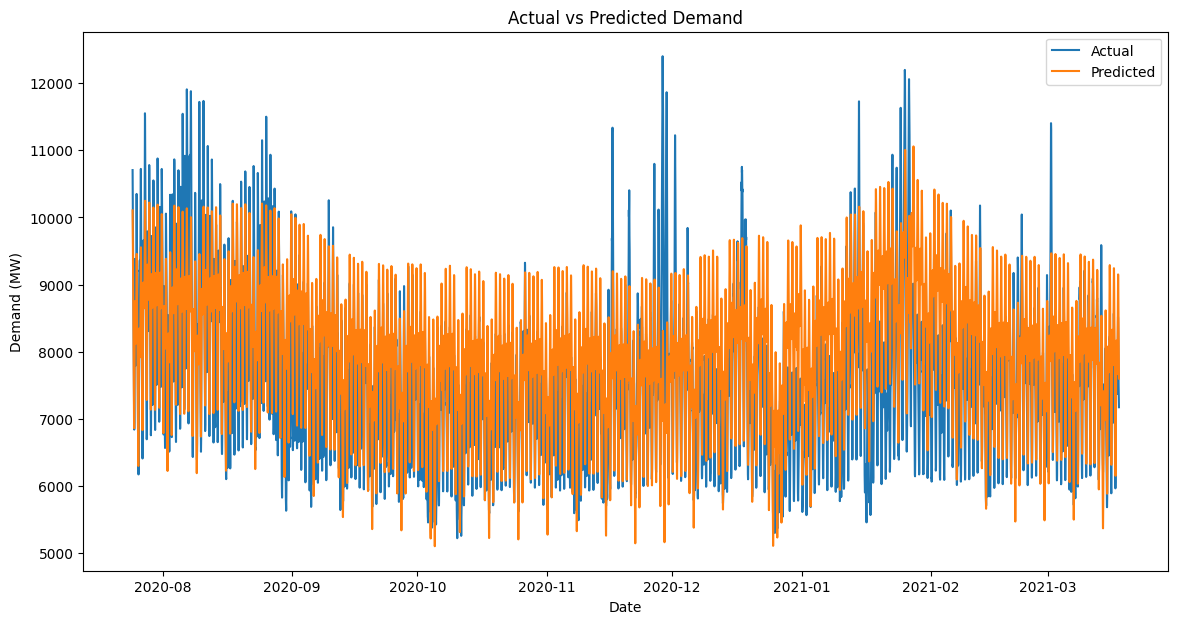

,ds,yhat,y
0,2020-07-24 19:00:00,10105.121989,10705.53
1,2020-07-24 19:30:00,10001.325293,10473.41
2,2020-07-24 20:00:00,9826.377017,10271.35
3,2020-07-24 20:30:00,9603.790784,10157.26
4,2020-07-24 21:00:00,9361.754864,9948.99


In [25]:
#univariate model
regressors = []
model1, result1 = prophet_model(df_model, regressors, train, test)
result1.head()

#### Model 2: Multivariate model with regressors temperature only 

14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 855645.9417949821
Root Mean Squared Error: 925.0113198199156
Mean Absolute Error: 743.4933406291176
Mean Absolute Percentage Error: 10.180796433726249%


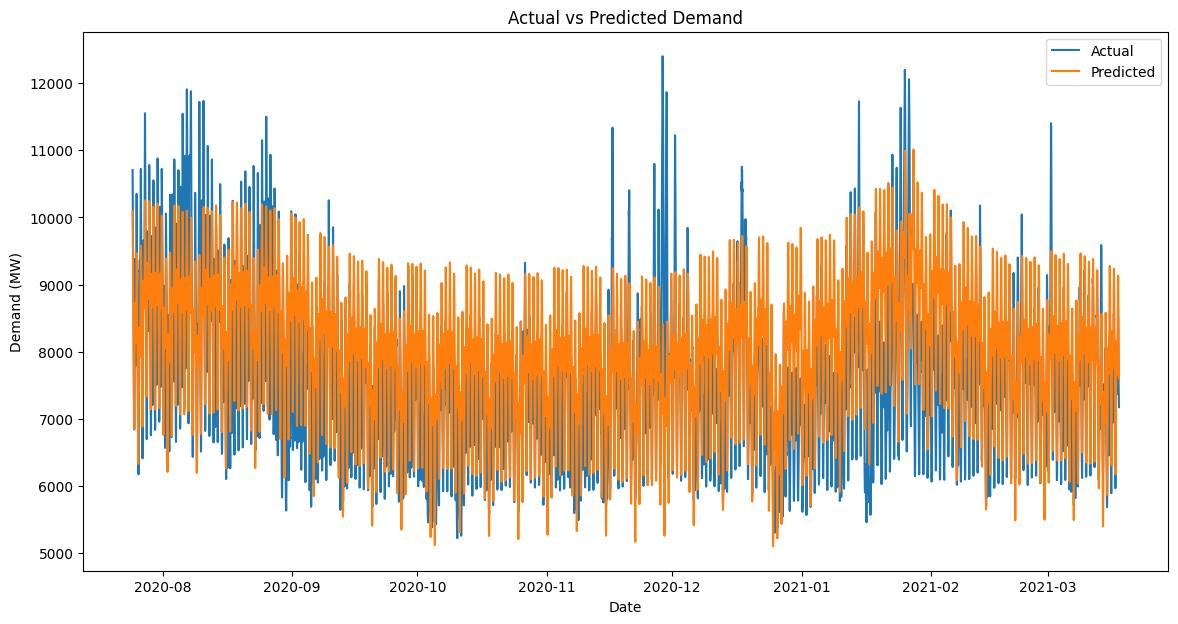

,ds,yhat,y
0,2020-07-24 19:00:00,10097.527835,10705.53
1,2020-07-24 19:30:00,9993.143556,10473.41
2,2020-07-24 20:00:00,9816.577517,10271.35
3,2020-07-24 20:30:00,9592.695119,10157.26
4,2020-07-24 21:00:00,9346.757204,9948.99


In [26]:
#Model 2: Multivariate model with regressors temperature only 
regressors = ['TEMPERATURE']

model2, result2 = prophet_model(df_model, regressors, train, test)
result2.head()

#### Model 3: Multivariate model with all regressors

14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 18634.722855661144
Root Mean Squared Error: 136.50905777881974
Mean Absolute Error: 111.86830254611957
Mean Absolute Percentage Error: 1.514809272946591%


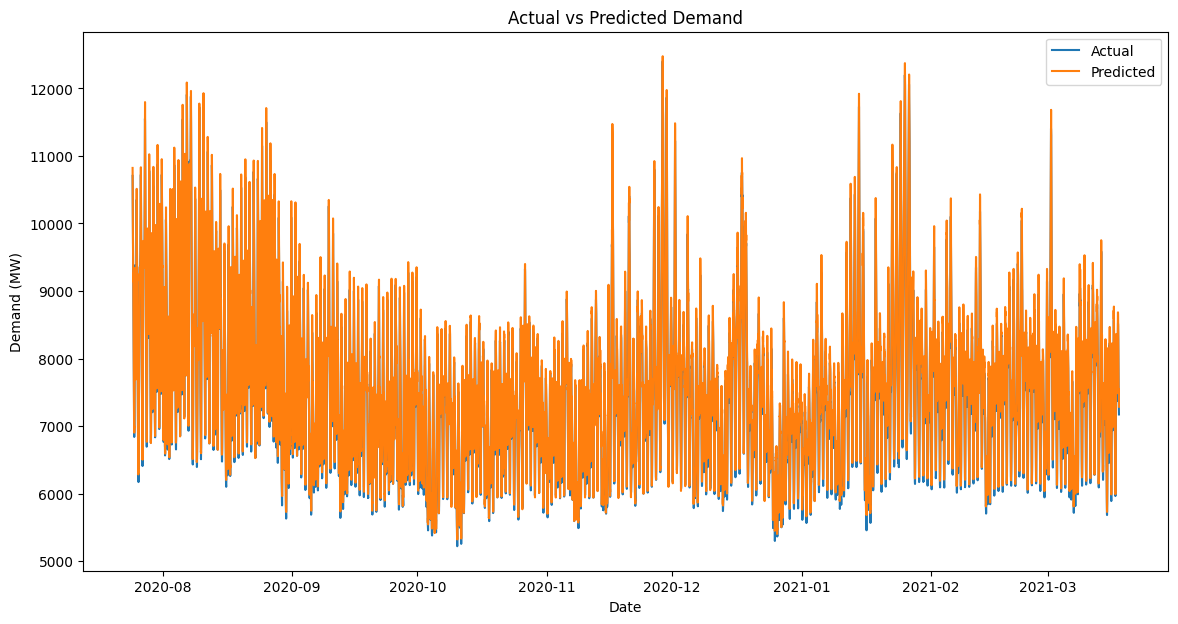

,ds,yhat,y
0,2020-07-24 19:00:00,10822.732584,10705.53
1,2020-07-24 19:30:00,10563.042177,10473.41
2,2020-07-24 20:00:00,10202.557137,10271.35
3,2020-07-24 20:30:00,10004.626983,10157.26
4,2020-07-24 21:00:00,9953.936286,9948.99


In [27]:
# Model 3: Multivariate model with all regressors temperature and seasonality
regressors = ['TEMPERATURE', 'HOUR', 'MONTH', 'SUMMER', 'AUTUMN', 'WINTER',
       'SPRING', 'PEAK', 'WEEKDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'lag_1', 'lag_2', 'lag_3']

model3, result3 = prophet_model(df_model, regressors, train, test)
result3.head()

#### Model 4: Multivariate model with regressors temperature and seasonality

14:56:16 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 17963.959445000313
Root Mean Squared Error: 134.0296961311198
Mean Absolute Error: 109.2907102381969
Mean Absolute Percentage Error: 1.4786376536011825%


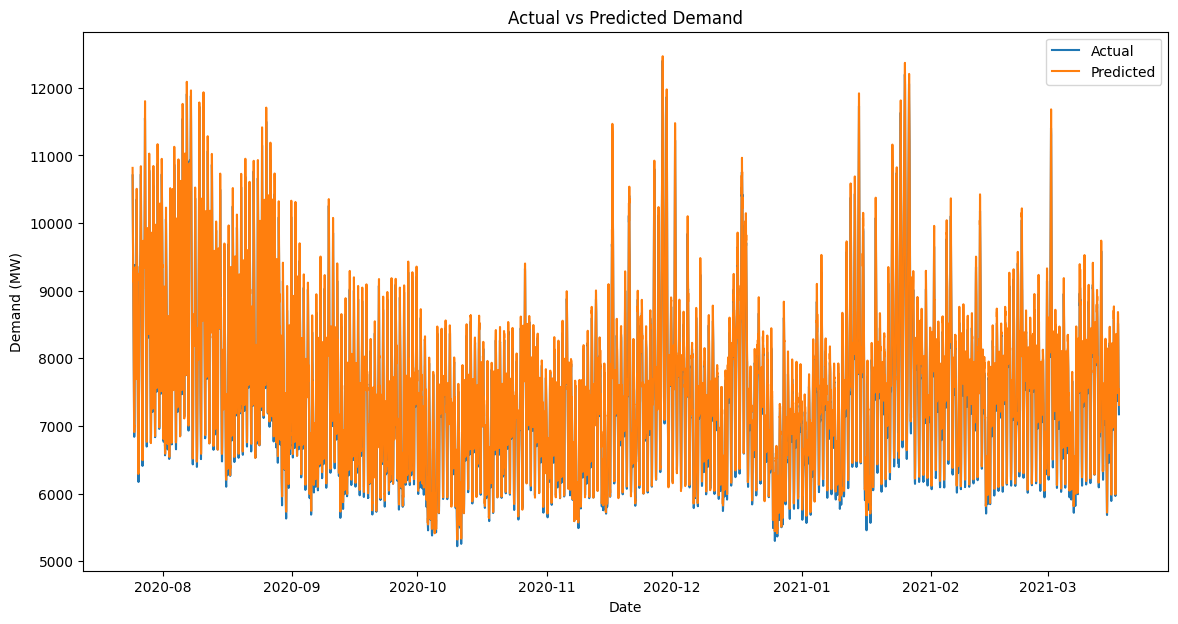

,ds,yhat,y
0,2020-07-24 19:00:00,10815.963862,10705.53
1,2020-07-24 19:30:00,10556.213983,10473.41
2,2020-07-24 20:00:00,10194.794489,10271.35
3,2020-07-24 20:30:00,9994.831759,10157.26
4,2020-07-24 21:00:00,9945.201501,9948.99


In [28]:
# Model 4: Multivariate model with regressors temperature and seasonality
regressors = ['TEMPERATURE', 'SUMMER', 'AUTUMN', 'WINTER', 'SPRING',
        'lag_1', 'lag_2', 'lag_3']

#call the function
model4, result4 = prophet_model(df_model, regressors, train, test)
result4.head()

#### Result comparison

In [30]:
#create a table with all the results
results_data = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])

results_data.loc[0] = ['Model 1', mean_squared_error(result1['y'], result1['yhat']), sqrt(mean_squared_error(result1['y'], result1['yhat'])), mean_absolute_error(result1['y'], result1['yhat']), mean_absolute_percentage_error(result1['y'], result1['yhat'])]

results_data.loc[1] = ['Model 2', mean_squared_error(result2['y'], result2['yhat']), sqrt(mean_squared_error(result2['y'], result2['yhat'])), mean_absolute_error(result2['y'], result2['yhat']), mean_absolute_percentage_error(result2['y'], result2['yhat'])]

results_data.loc[2] = ['Model 3', mean_squared_error(result3['y'], result3['yhat']), sqrt(mean_squared_error(result3['y'], result3['yhat'])), mean_absolute_error(result3['y'], result3['yhat']), mean_absolute_percentage_error(result3['y'], result3['yhat'])]

results_data.loc[3] = ['Model 4', mean_squared_error(result4['y'], result4['yhat']), sqrt(mean_squared_error(result4['y'], result4['yhat'])), mean_absolute_error(result4['y'], result4['yhat']), mean_absolute_percentage_error(result4['y'], result4['yhat'])]

results_data

,Model,MSE,RMSE,MAE,MAPE
0,Model 1,860668.338135,927.722123,743.569985,0.101773
1,Model 2,855645.941795,925.011320,743.493341,0.101808
2,Model 3,18634.722856,136.509058,111.868303,0.015148
3,Model 4,17963.959445,134.029696,109.290710,0.014786


So far model4 performed better than all. Now we plot the Scatterplot for actual and predicted for model 4. 

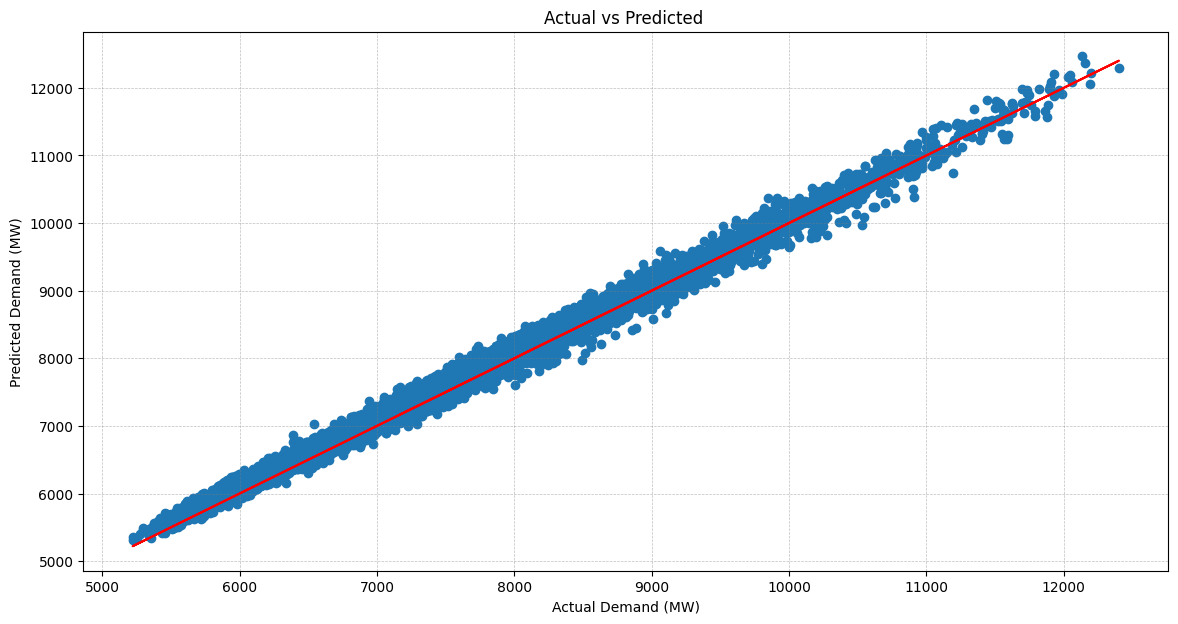

In [31]:
#scatter plot y vs y_hat
plt.figure(figsize=(14, 7))
plt.scatter(result4['y'], result4['yhat'])
plt.plot(result4['y'], result4['y'], color='red')
plt.xlabel('Actual Demand (MW)')
plt.ylabel('Predicted Demand (MW)')
plt.title('Actual vs Predicted ')
#plot grid
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha = 0.5)

plt.show()

As in the plot we see that the points are clustered and close to the diagonal line, that suggests that the model is fairly accurate.

#### Coefficient plots

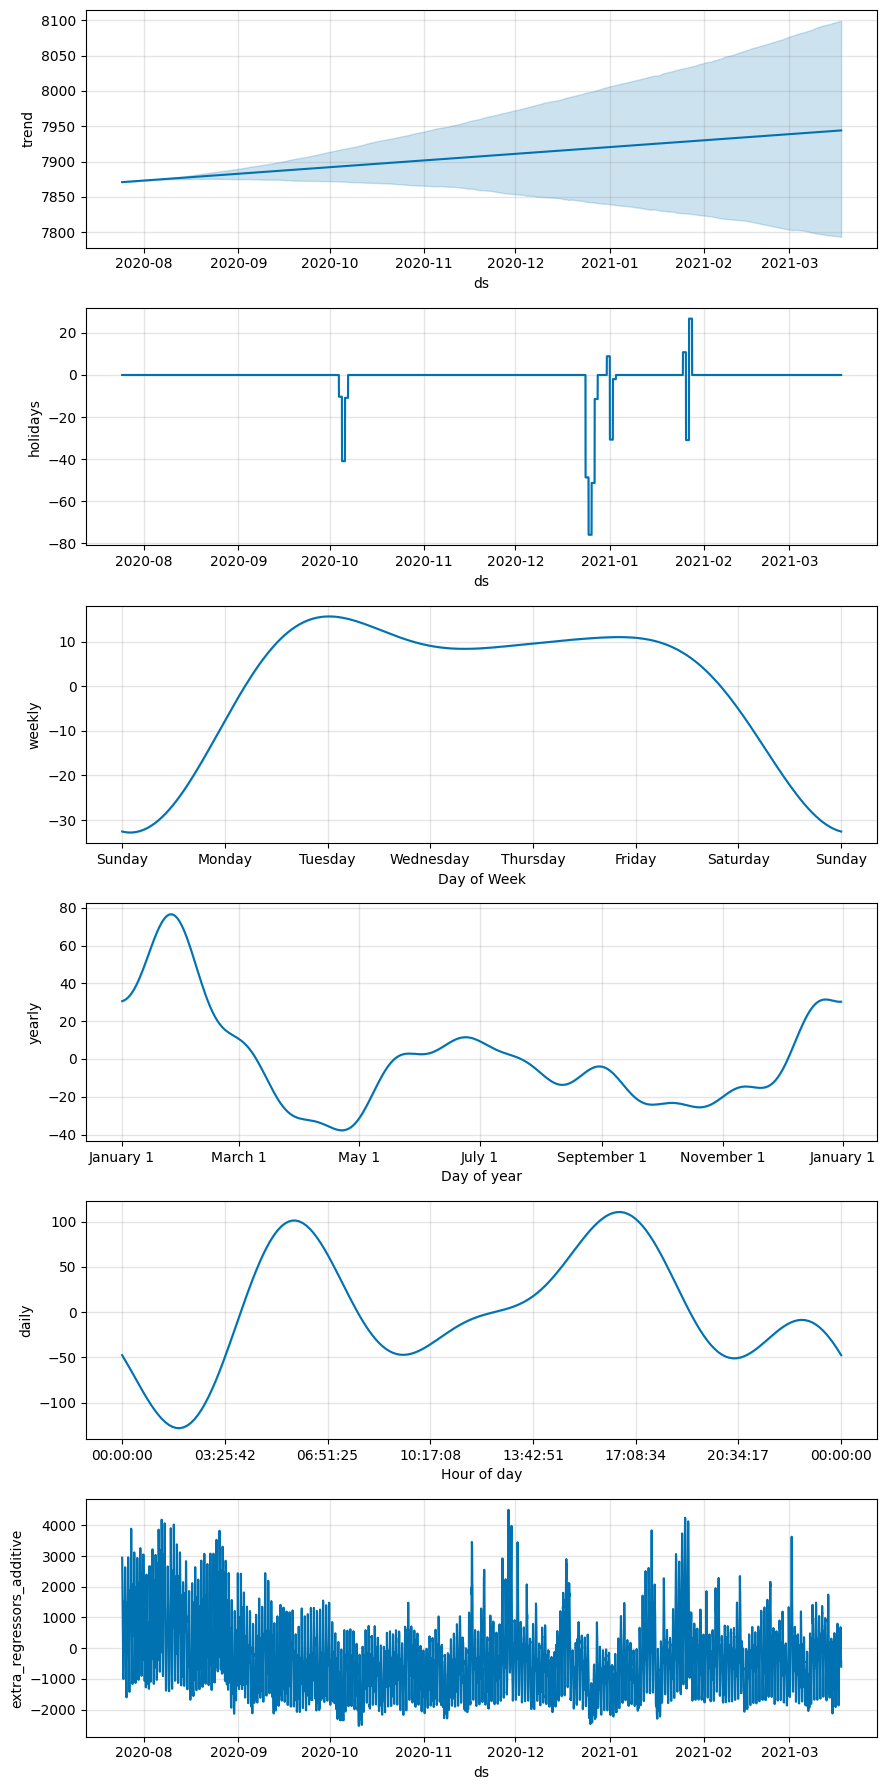

In [32]:
#component plots for model 4
model4.plot_components(model4.predict(test))
plt.show()

#### Forecast

Create a future dataset to forecast. 

In [33]:
#create a dataframe with from 2021-01-01 to 2021-01-02 copied from the test set
future = df.copy()
future = future[(future['ds'] >= '2021-03-01') & (future['ds'] < '2021-03-18')]


In [34]:
#forecast for the future data
forecast = model4.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-03-01 00:00:00,7147.090203,7003.051298,7282.671662
1,2021-03-01 00:30:00,7114.760534,6975.008999,7245.049575
2,2021-03-01 01:00:00,6894.313965,6757.704556,7037.787037
3,2021-03-01 01:30:00,6680.790452,6536.867089,6824.476557
4,2021-03-01 02:00:00,6364.387084,6227.099577,6497.889658
...,...,...,...,...
811,2021-03-17 21:30:00,7510.209287,7382.656509,7648.750312
812,2021-03-17 22:00:00,7546.237136,7407.212004,7675.658507
813,2021-03-17 22:30:00,7473.288686,7338.280535,7606.231008
814,2021-03-17 23:00:00,7513.929442,7375.858173,7651.796231


In [35]:
#join the forecast with the actual values
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] 
forecast = forecast.set_index('ds')
future = future.set_index('ds')
future = future[['y']]
forecast = forecast.join(future)
#add column y-yhat
forecast['y-yhat'] = forecast['y'] - forecast['yhat']
forecast.head()

,yhat,yhat_lower,yhat_upper,y,y-yhat
ds,,,,,
2021-03-01 00:00:00,7147.090203,7003.051298,7282.671662,7102.38,-44.710203
2021-03-01 00:30:00,7114.760534,6975.008999,7245.049575,6947.85,-166.910534
2021-03-01 01:00:00,6894.313965,6757.704556,7037.787037,6769.28,-125.033965
2021-03-01 01:30:00,6680.790452,6536.867089,6824.476557,6499.29,-181.500452
2021-03-01 02:00:00,6364.387084,6227.099577,6497.889658,6336.15,-28.237084


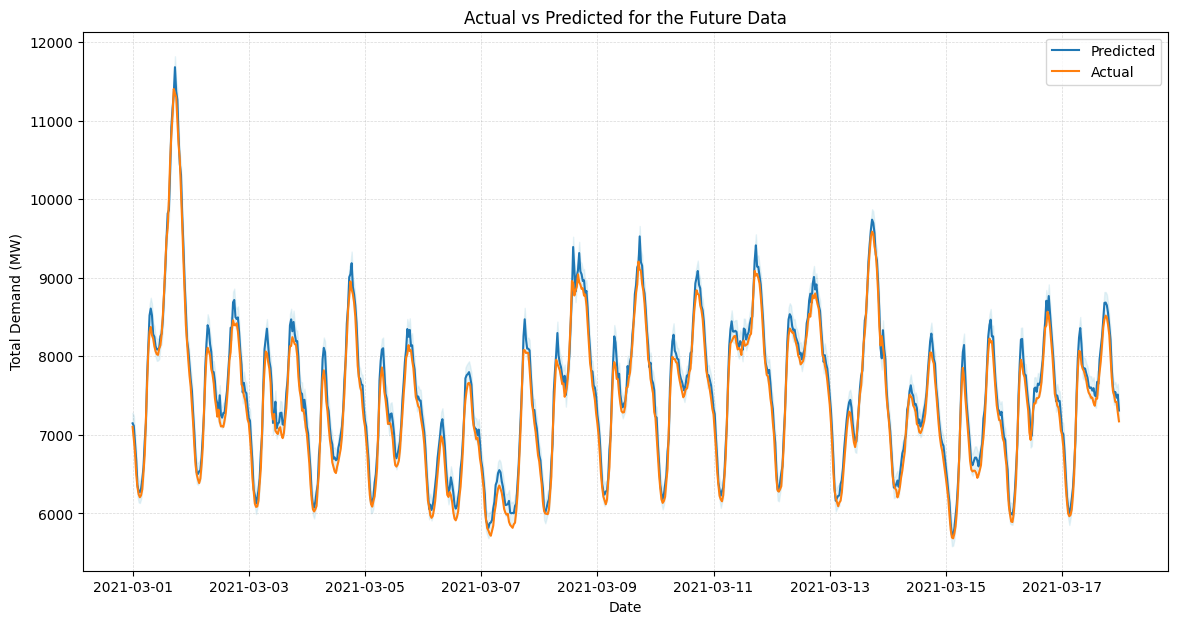

In [36]:
#plot y vs yhat for the future data
plt.figure(figsize=(14, 7))
plt.plot(forecast['yhat'], label='Predicted')
#plot the confidence intervals
plt.fill_between(forecast.index, forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.3)
plt.plot(forecast['y'], label='Actual')
#plot light grid
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5 , alpha = 0.3)
plt.legend()
#label x and y axis
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.title('Actual vs Predicted for the Future Data')
plt.show()

Showing one day forecast only for 2021-03-01.

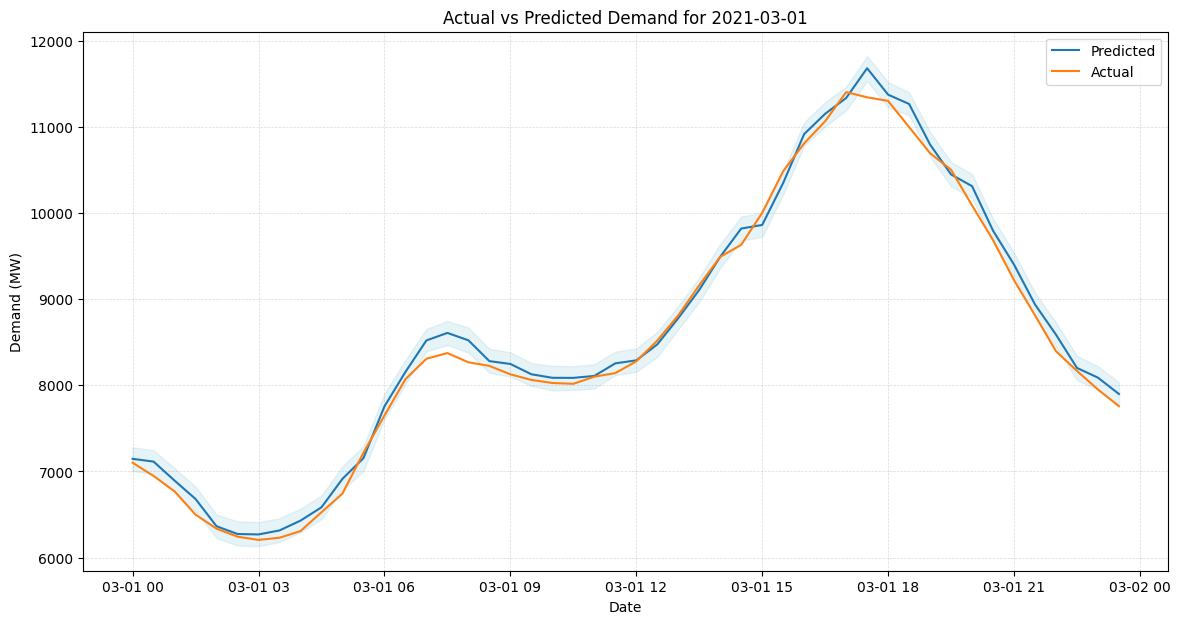

In [37]:
#filter data for 2021-03-01
forecast_2021_03_01 = forecast[(forecast.index >= '2021-03-01') & (forecast.index < '2021-03-02')]

#plot y vs yhat only for ds 03-01-2021
plt.figure(figsize=(14, 7))
plt.plot(forecast_2021_03_01['yhat'], label='Predicted')
#plot the confidence intervals
plt.fill_between(forecast_2021_03_01.index, forecast_2021_03_01['yhat_lower'], forecast_2021_03_01['yhat_upper'], color='lightblue', alpha=0.3)
plt.plot(forecast_2021_03_01['y'], label='Actual')
#plot light grid
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.ylabel('Demand (MW)')
plt.xlabel('Date')
plt.title('Actual vs Predicted Demand for 2021-03-01')
plt.legend()
plt.show()

Calculate MAE and MAPE for forecast:

In [38]:
#calculate the mean absolute percentage error for the forecasted data
mape_forecast = mean_absolute_percentage_error(forecast['y'], forecast['yhat']) 
print(f'Mean Absolute Percentage Error: {mape_forecast*100}%')
mae_forecast = mean_absolute_error(forecast['y'], forecast['yhat'])
print(f'Mean Absolute Error: {mae_forecast}')


Mean Absolute Percentage Error: 1.797144937057603%
Mean Absolute Error: 132.15816649216157


#### Cross Validation

We are performing forward-chaining cross-validation, also known as rolling-origin cross-validation. This is similar to k-fold cross-validation but is better suited to sequential data such as time series. There is no random shuffling of data to begin with, but a test set may be set aside. Here we have performed a 5-fold validation on train data setting the initial 420 days so it can capture the yearly seasonality and we also set the period to 90 days and horizon 15 days.  

In [39]:
# setting custom cutoffs for cross validation
df_cv = cross_validation(model4, initial='420 days', period='90 days', horizon='15 days')
df_cv.head()

  0%|          | 0/5 [00:00<?, ?it/s]

14:57:51 - cmdstanpy - INFO - Chain [1] start processing
14:57:54 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:58:01 - cmdstanpy - INFO - Chain [1] done processing
14:58:04 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-15 19:00:00,11215.494799,11074.667323,11366.847955,11150.91,2019-07-15 18:30:00
1,2019-07-15 19:30:00,11019.457328,10867.996320,11160.642374,10971.07,2019-07-15 18:30:00
2,2019-07-15 20:00:00,10721.005346,10566.773003,10864.924339,10727.91,2019-07-15 18:30:00
3,2019-07-15 20:30:00,10426.398670,10273.917609,10581.080423,10578.34,2019-07-15 18:30:00
4,2019-07-15 21:00:00,10328.817930,10179.736698,10473.344058,10369.10,2019-07-15 18:30:00


Performance metrices:

In [40]:
from prophet.diagnostics import performance_metrics
df_performance = performance_metrics(df_cv)

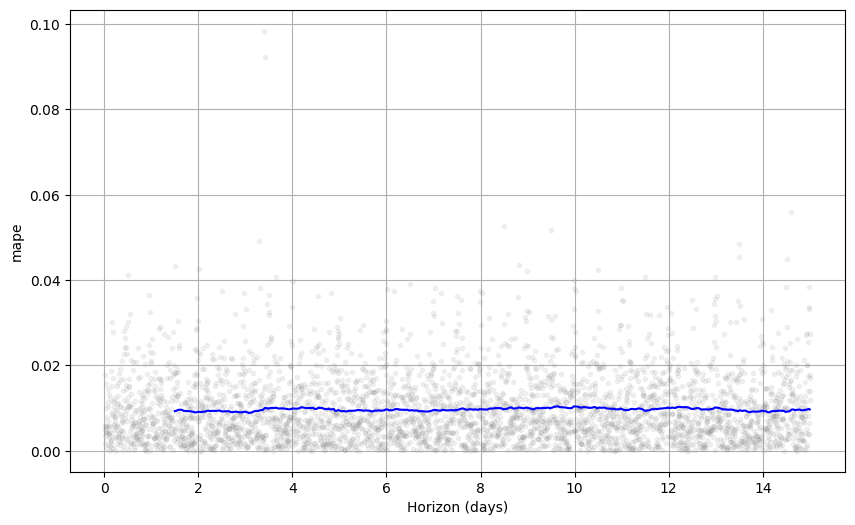

In [41]:
#plotting the mape for the cross validation
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Let's see the cutoff points:

In [42]:
#get the unique values of cutoff column and create a dataframe
cutoffs = df_cv['cutoff'].unique()
cutoffs

<DatetimeArray>
['2019-07-15 18:30:00', '2019-10-13 18:30:00', '2020-01-11 18:30:00',
 '2020-04-10 18:30:00', '2020-07-09 18:30:00']
Length: 5, dtype: datetime64[ns]

Plotting cross-validation results:

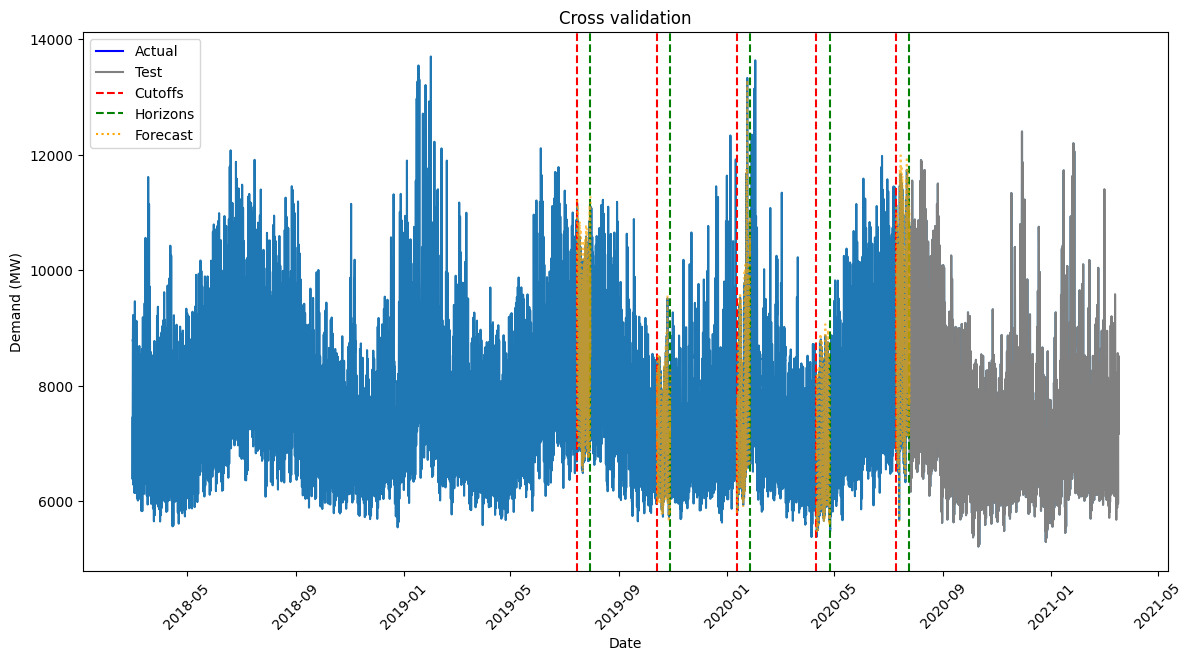

In [43]:
#plot the crossvalidation results
plt.figure(figsize=(14, 7))
plt.plot(df_model['ds'], df_model['y'])
plt.plot(test['ds'], test['y'], color='grey')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Demand (MW)')
#draw vertical lines for the cutoffs
for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='red', linestyle='--')
#draw vertical lines for the horizon
plt.axvline(x=cutoffs[0] + pd.Timedelta('15 days'), color='green', linestyle='--')
plt.axvline(x=cutoffs[1] + pd.Timedelta('15 days'), color='green', linestyle='--')
plt.axvline(x=cutoffs[2] + pd.Timedelta('15 days'), color='green', linestyle='--')
plt.axvline(x=cutoffs[3] + pd.Timedelta('15 days'), color='green', linestyle='--')
plt.axvline(x=cutoffs[4] + pd.Timedelta('15 days'), color='green', linestyle='--')


#plot forecast for the horizon for each cutoff
for cutoff in cutoffs:
    plt.plot(df_cv[df_cv['cutoff'] == cutoff]['ds'], df_cv[df_cv['cutoff'] == cutoff]['yhat'], color='orange', linestyle=':', alpha=0.7)
plt.title('Cross validation')
# Create legend handles and labels
handles = [plt.Line2D([0], [0], color='blue', label='Actual'), 
           plt.Line2D([0], [0], color='grey', label='Test'), 
           plt.Line2D([0], [0], color='red', linestyle='--', label='Cutoffs'),
           plt.Line2D([0], [0], color='green', linestyle='--', label='Horizons'), 
           plt.Line2D([0], [0], color='orange', linestyle=':', label='Forecast')]
# handles = [Actual, Cutoffs]
labels = ['Actual', 'Test', 'Cutoffs', 'Horizons','Forecast']
# Add legend
plt.legend(handles=handles, labels=labels)
plt.show()


In [44]:
#create a new column for MSE in df_cv
df_cv['MSE'] = (df_cv['y'] - df_cv['yhat'])**2
#create a new column for RMSE in df_cv
df_cv['RMSE'] = np.sqrt(df_cv['MSE'])
#create a new column for MAE in df_cv
df_cv['MAE'] = np.abs(df_cv['y'] - df_cv['yhat'])
#create a new column for MAPE in df_cv
df_cv['MAPE'] = np.abs((df_cv['y'] - df_cv['yhat'])/df_cv['y'])*100
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,MSE,RMSE,MAE,MAPE
0,2019-07-15 19:00:00,11215.494799,11074.667323,11366.847955,11150.91,2019-07-15 18:30:00,4171.196247,64.584799,64.584799,0.579189
1,2019-07-15 19:30:00,11019.457328,10867.996320,11160.642374,10971.07,2019-07-15 18:30:00,2341.333522,48.387328,48.387328,0.441045
2,2019-07-15 20:00:00,10721.005346,10566.773003,10864.924339,10727.91,2019-07-15 18:30:00,47.674249,6.904654,6.904654,0.064362
3,2019-07-15 20:30:00,10426.398670,10273.917609,10581.080423,10578.34,2019-07-15 18:30:00,23086.167874,151.941330,151.941330,1.436344
4,2019-07-15 21:00:00,10328.817930,10179.736698,10473.344058,10369.10,2019-07-15 18:30:00,1622.645156,40.282070,40.282070,0.388482


In [61]:

#show only cutoffs and mean values for MSE, RMSE, MAE, MAPE
df_cv.groupby('cutoff').mean()[['MSE', 'RMSE', 'MAE', 'MAPE']]


,MSE,RMSE,MAE,MAPE
cutoff,,,,
2019-07-15 18:30:00,13920.905673,87.609960,87.609960,1.004908
2019-10-13 18:30:00,6465.128089,63.238098,63.238098,0.881643
2020-01-11 18:30:00,10061.932985,77.705330,77.705330,0.961093
2020-04-10 18:30:00,8314.677759,66.028397,66.028397,0.945156
2020-07-09 18:30:00,16096.508175,92.953301,92.953301,1.040491


#### Model size

In [47]:
# Get the size of the model object in bytes
import sys
model_size = sys.getsizeof(model4)
print(f"Prophet model size: {model_size} bytes")



Prophet model size: 48 bytes


#### Export model

In [48]:
#export the model
import os
import joblib

#create a new folder to save the model
if not os.path.exists('../models'):
    os.makedirs('../models')
joblib.dump(model4, '../models/prophet_model.pkl')



['../models/prophet_model.pkl']

#### Export the forecast

In [49]:
#export model forecast
#create a new folder to save the forecast
if not os.path.exists('../results'):
    os.makedirs('../results')

forecast.to_csv('../results/forecast_prophet_model.csv')


#### Plot AEMO forecast and XGBoost forecast 

At first read the combined csv XGBoost prediction and AEMO forecast. 

In [50]:
#read the xgb_prediction file
final_forecast = pd.read_csv('../results/xgb_aemo_predictions.csv')

In [51]:
#copy ds and yhat to a new dataframe
forecast_prophet = forecast[['yhat']]

In [52]:
forecast_prophet.head()

,yhat
ds,
2021-03-01 00:00:00,7147.090203
2021-03-01 00:30:00,7114.760534
2021-03-01 01:00:00,6894.313965
2021-03-01 01:30:00,6680.790452
2021-03-01 02:00:00,6364.387084


In [53]:
#copy the yhat column to the final_forecast dataframe
final_forecast['PROPHETPREDICTION'] = forecast_prophet['yhat'].values



In [54]:
final_forecast.head()

,DATETIME,TOTALDEMAND,FORECASTDEMAND,XGBPREDICTION,PROPHETPREDICTION
0,2021-03-01 00:00:00,7102.38,6888.226338,6996.4550,7147.090203
1,2021-03-01 00:30:00,6947.85,6689.353472,6962.2660,7114.760534
2,2021-03-01 01:00:00,6769.28,6482.016301,6749.2593,6894.313965
3,2021-03-01 01:30:00,6499.29,6246.177838,6530.3430,6680.790452
4,2021-03-01 02:00:00,6336.15,6084.376800,6319.4688,6364.387084


In [55]:
#change the format of the DATETIME column to datetime
final_forecast['DATETIME'] = pd.to_datetime(final_forecast['DATETIME'])

AEMO prediction vs Prohet's prediction:

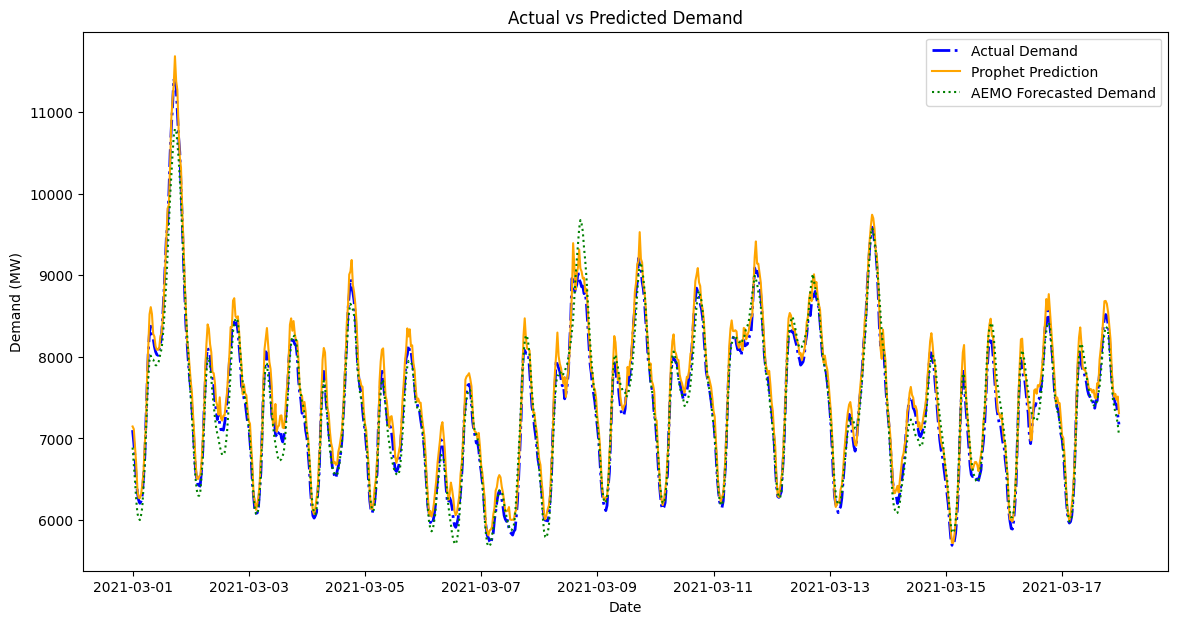

In [56]:
#plot the actual vs predicted for the final forecast of AEMO model and Prophet
plt.figure(figsize=(14, 7))
plt.plot(final_forecast['DATETIME'], final_forecast['TOTALDEMAND'], label='Actual Demand', color='blue',linestyle='-.',linewidth=2)
plt.plot(final_forecast['DATETIME'], final_forecast['PROPHETPREDICTION'], label='Prophet Prediction', color='orange')
plt.plot(final_forecast['DATETIME'], final_forecast['FORECASTDEMAND'], label='AEMO Forecasted Demand', color='green',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

    

Plot Prophet vs XGBoost:

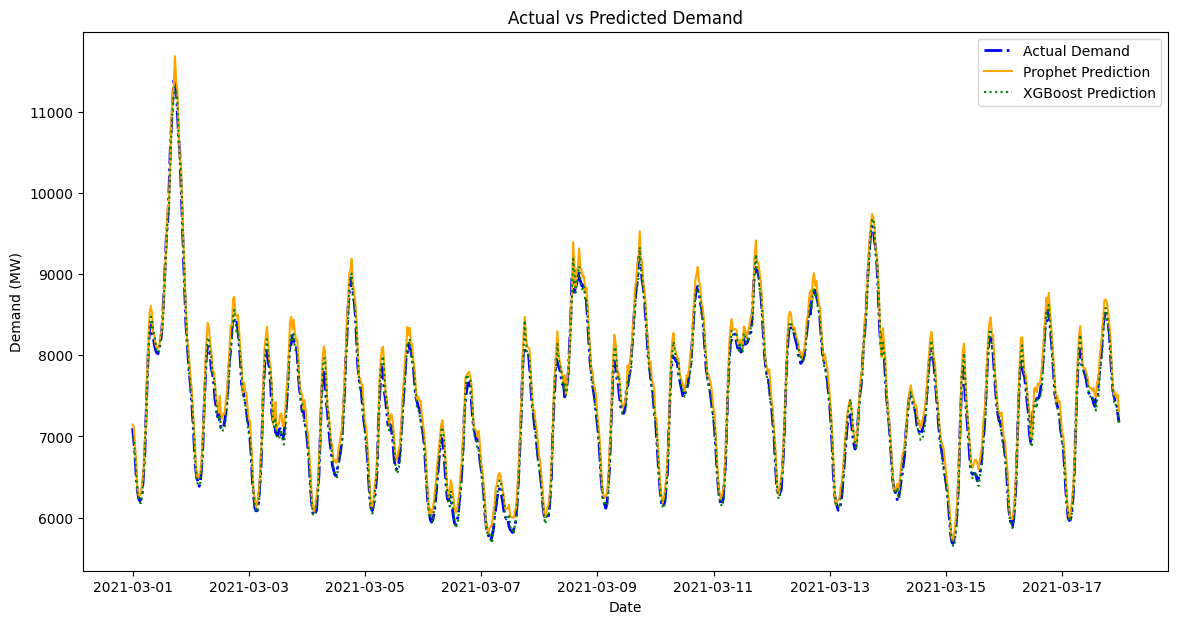

In [57]:
#plot the actual vs predicted for the final forecast of AEMO model and Prophet
plt.figure(figsize=(14, 7))
plt.plot(final_forecast['DATETIME'], final_forecast['TOTALDEMAND'], label='Actual Demand', color='blue',linestyle='-.',linewidth=2)
plt.plot(final_forecast['DATETIME'], final_forecast['PROPHETPREDICTION'], label='Prophet Prediction', color='orange')
plt.plot(final_forecast['DATETIME'], final_forecast['XGBPREDICTION'], label='XGBoost Prediction', color='green',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

Single day forecast comparison:

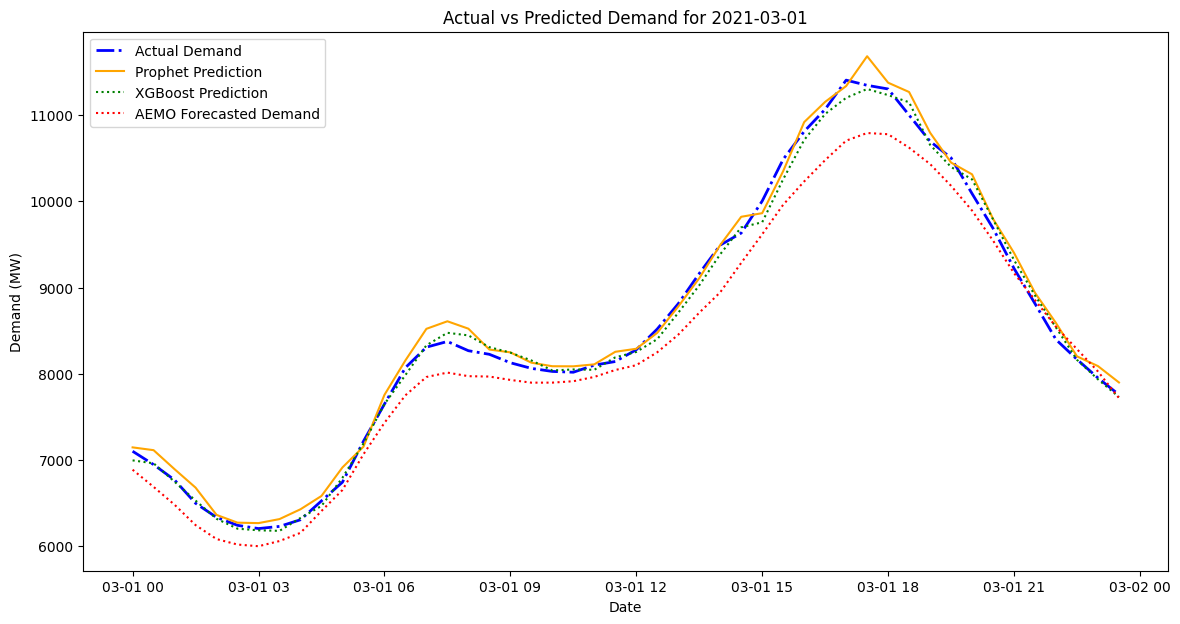

In [58]:
#plot XGBoost vs Prophet for a single day
final_forecast_2021_03_01 = final_forecast[(final_forecast['DATETIME'] >= '2021-03-01') & (final_forecast['DATETIME'] < '2021-03-02')]

plt.figure(figsize=(14, 7))

plt.plot(final_forecast_2021_03_01['DATETIME'], final_forecast_2021_03_01['TOTALDEMAND'], label='Actual Demand', color='blue',linestyle='-.',linewidth=2)
plt.plot(final_forecast_2021_03_01['DATETIME'], final_forecast_2021_03_01['PROPHETPREDICTION'], label='Prophet Prediction', color='orange')
plt.plot(final_forecast_2021_03_01['DATETIME'], final_forecast_2021_03_01['XGBPREDICTION'], label='XGBoost Prediction', color='green',linestyle=':')
plt.plot(final_forecast_2021_03_01['DATETIME'], final_forecast_2021_03_01['FORECASTDEMAND'], label='AEMO Forecasted Demand', color='red',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Actual vs Predicted Demand for 2021-03-01')
plt.legend()
plt.show()

    

Forecast for all future days:

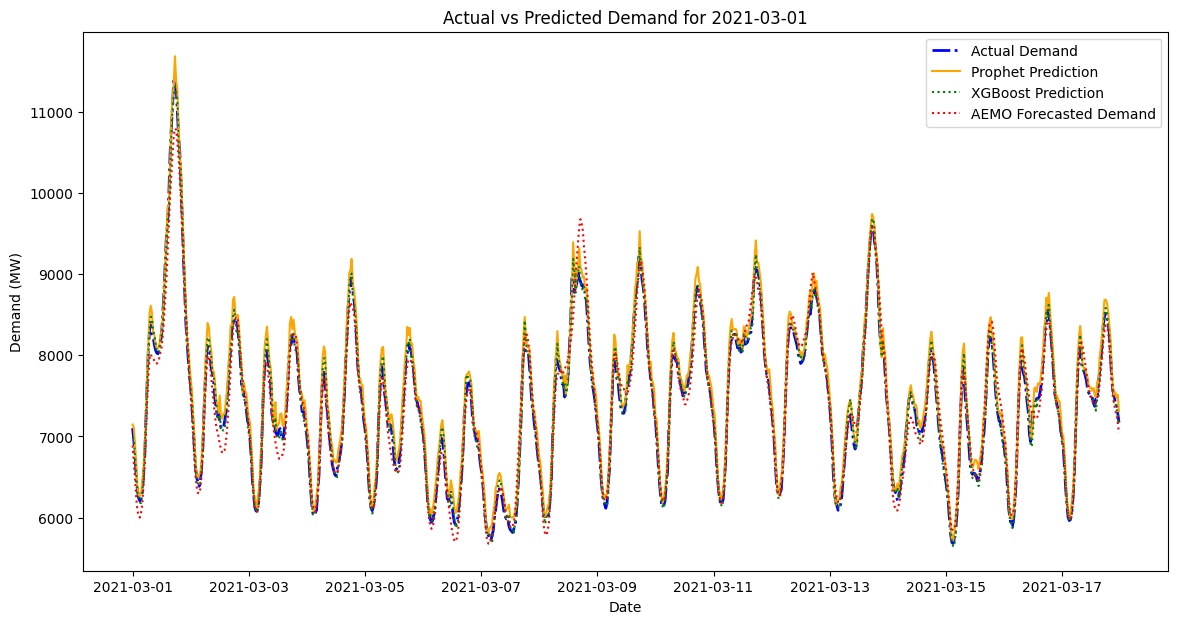

In [59]:
#plot XGBoost vs Prophet for all future days
plt.figure(figsize=(14, 7))

plt.plot(final_forecast['DATETIME'], final_forecast['TOTALDEMAND'], label='Actual Demand', color='blue',linestyle='-.',linewidth=2)
plt.plot(final_forecast['DATETIME'], final_forecast['PROPHETPREDICTION'], label='Prophet Prediction', color='orange')
plt.plot(final_forecast['DATETIME'], final_forecast['XGBPREDICTION'], label='XGBoost Prediction', color='green',linestyle=':')
plt.plot(final_forecast['DATETIME'], final_forecast['FORECASTDEMAND'], label='AEMO Forecasted Demand', color='red',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Actual vs Predicted Demand for 2021-03-01')
plt.legend()
plt.show()